In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, Dense, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.layers import GRU
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, f1_score, accuracy_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset.tsv', sep='\t')
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(99999, 2)

In [ ]:
# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']

    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)

    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)

    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')

    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])

    #trim
    text = text.strip()

    return text

In [ ]:
df['label_id'] = df['label'].map({'Negative': 0, 'Mixed': 1, 'Positive': 2})

In [ ]:
df['sentence_embedding'] = df['text'].apply(clean_str)

In [ ]:
df.head()

,label,text,label_id,sentence_embedding
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,2,ممتاز نوعا ما النظافه والموقع والتجهيز والشاط...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,2,احد اسباب نجاح الامارات ان كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,2,هادفه وقويه تنقلك من صخب شوارع القاهره الي هد...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,2,خلصنا مبدئيا اللي مستني ابهار زي الفيل الازرق...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,2,ياسات جلوريا جزء لا يتجزا من دبي فندق متكامل ...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence_embedding'], df['label_id'], test_size=0.1, stratify=df['label_id'], random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(encoded_train[0])

[92, 142, 12606, 2, 547]


In [ ]:
max_length = 30
padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

print(padded_train)
padded_train.shape , padded_test.shape

[[    92    142  12606 ...      0      0      0]
 [ 28956  16814  11171 ...      2   1051   5058]
 [  6345   4646      2 ... 122619     60   2865]
 ...
 [ 32254  35891   1069 ...  13444   5174  23584]
 [    32    969     11 ...    455   1020   2426]
 [ 13408  11323    683 ...      0      0      0]]


((89999, 30), (10000, 30))

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(LSTM(16, return_sequences=False, activation='tanh'))
model.add(Dense(3, activation='softmax'))

In [ ]:
custom_optimizer = RMSprop(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 10)            2691130   
                                                                 
 lstm (LSTM)                 (None, 16)                1728      
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2692909 (10.27 MB)
Trainable params: 2692909 (10.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history=model.fit(x=padded_train, y=y_train, epochs=100, validation_data=(padded_test, y_test), verbose=1, batch_size=512,
          callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

Epoch 1/100
176/176 [==============================] - 12s 51ms/step - loss: 1.0791 - accuracy: 0.3769 - val_loss: 0.9572 - val_accuracy: 0.5046
Epoch 2/100
176/176 [==============================] - 8s 43ms/step - loss: 0.8997 - accuracy: 0.5434 - val_loss: 0.8647 - val_accuracy: 0.5712
Epoch 3/100
176/176 [==============================] - 8s 47ms/step - loss: 0.8060 - accuracy: 0.6171 - val_loss: 0.8710 - val_accuracy: 0.5708
Epoch 4/100
176/176 [==============================] - 8s 48ms/step - loss: 0.7459 - accuracy: 0.6621 - val_loss: 0.8697 - val_accuracy: 0.5818
Epoch 5/100
176/176 [==============================] - 7s 42ms/step - loss: 0.6926 - accuracy: 0.6986 - val_loss: 0.8903 - val_accuracy: 0.5847
Epoch 6/100
176/176 [==============================] - 9s 50ms/step - loss: 0.6420 - accuracy: 0.7316 - val_loss: 0.9164 - val_accuracy: 0.5893
Epoch 7/100
176/176 [==============================] - 7s 40ms/step - loss: 0.5808 - accuracy: 0.7659 - val_loss: 0.8838 - val_accuracy

In [ ]:
preds = (model.predict(padded_test) > 0.5).astype("int32")

313/313 [==============================] - 1s 4ms/step


In [ ]:
predicted_labels = np.argmax(preds, axis=1)
print(predicted_labels)

[0 1 0 ... 1 2 2]


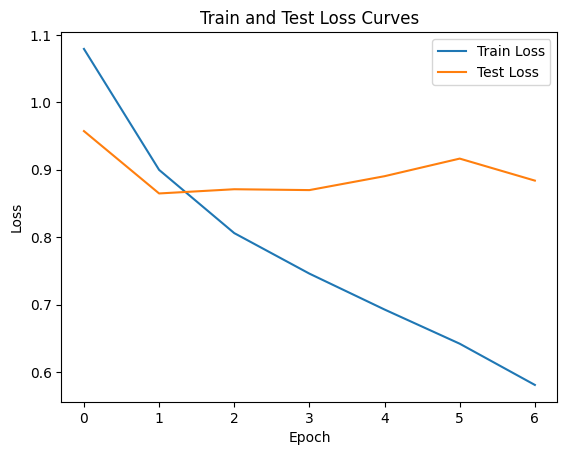

In [ ]:
# Plot separate curves for train and test loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Curves')
plt.legend()
plt.show()


313/313 [==============================] - 1s 4ms/step


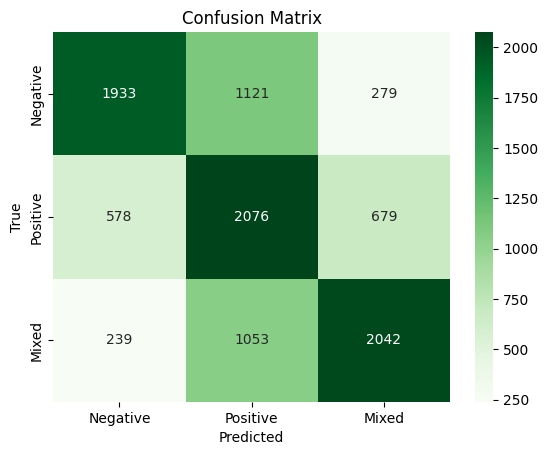

              precision    recall  f1-score   support

    Negative       0.70      0.58      0.64      3333
    Positive       0.49      0.62      0.55      3333
       Mixed       0.68      0.61      0.64      3334

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000



In [ ]:

# 3. Show classification report and confusion matrix in green color
preds = model.predict(padded_test)
predicted_labels = np.argmax(preds, axis=1)

# Generate the classification report
class_report = classification_report(y_test, predicted_labels, target_names=['Negative', 'Positive', 'Mixed'])

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix in green color
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive', 'Mixed'], yticklabels=['Negative', 'Positive', 'Mixed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(class_report)

In [ ]:
report = classification_report(y_test, predicted_labels)
print("Classification Report:")
print(report)
cm = confusion_matrix(y_test, predicted_labels)

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64      3333
           1       0.49      0.62      0.55      3333
           2       0.68      0.61      0.64      3334

    accuracy                           0.61     10000
   macro avg       0.62      0.61      0.61     10000
weighted avg       0.62      0.61      0.61     10000



In [ ]:
examples = [
    "هذا الفيلم غير مقنع على الإطلاق. القصة ضعيفة والأداء سيء.",
    "زرت هذا المطعم وكانت تجربة رائعة. الأكل لذيذ والجو جميل.",
    "الكتاب مثير للاهتمام ولكنه طويل جدًا. الأفكار ممتعة ولكن التنفيذ غير مثالي."
]


In [ ]:
cleaned_examples = [clean_str(example) for example in examples]
encoded_examples = tokenizer.texts_to_sequences(cleaned_examples)
padded_examples = pad_sequences(encoded_examples, maxlen=max_length, padding='post')

In [ ]:
pred = (model.predict(padded_examples) > 0.5).astype("int32")
print(pred)

1/1 [==============================] - 0s 20ms/step
[[1 0 0]
 [0 0 1]
 [0 1 0]]
